# Regulons with inverse profiles - parameter selection

Previously, a graph of genes with oposite (inverse) profiles was constructed (Orange Regulons workflow). However, there were many connections with genes that had expression across samples mostly 0, with a few small peaks (which might have been even techical artefacts, due to their low size and unclear pattern among replicates and strains). After log transformation and 0 to 1 scaling these profiles yelded relatively high cosine similarity to profiles of highly expressed genes that had valley in expression pattern at the same position, although the rest of pattern was not similar - thus leaeding to most likely false positive associations.

In order to reduce the effects of genes that have only a few above zero expression values in a couple of samples the similarities between genes were computed on each replicate separately, excluding genes that have all 0 expression values in individual replicates. Afterwards, the pairs between genes would be retained if there was more than N replicates with profile similarity above similarity threshold (described below). Previously (and on non-inverse profiles) only similarity threshold was used as all replicates were analysed as a single profile.

Similarities of inverse profiles were then used for network construction as before (egdge=similarity, nodes=genes). This graph had some star shaped sub-parts, which were also connected to other nodes. As connections are based on oposite profiles there are also connections over intermediate nodes between genes with similar profiles, which makes graph harder to comprehend. For example, if there is a connection A-B-C-D (nodes A,B,C,D) A and C both have oposite profile to B and also similar profiles to each other. A also has similar profile to D, althought this connection might have been filtered out due to threshold applied before graph construction. Thus it was decided that genes with strongly similar inverse profiles will be selected, as was done before for non-inverse profile based regulons. These genes will be used for further identification of gene groups with opposite profiles via clustering and visualisation of clusters on graph. Thus it was required to determine how gene pairs with oposite profiles will be filtered to obtain "selected genes" and connections for netwrok.

In [32]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

import library_regulons
reload(library_regulons)
from library_regulons import *

from functionsDENet import loadPickle
import jupyter_functions as jf

plt.rcParams['figure.figsize'] = [7, 7]


## Selection of min N of replicates and similarity threshold 

Similarities between genes, where one profiles is inversed, are computed as on individual replicates with same prepocessing as before: log transformation and scaling each gene from 0 to 1. For each gene 200 closest neighbours are computed, from which gene pairs are obtained. To determine which parameters are most reliable replicate data is subseted in 2 equal parts of non overlaping replicates (24 and 24 replicates out of 49 total) and results computed on both of them are compared.

On both of them gene pairs present in more than N replicates with similarity higher than threshold are selected. All genes included in selected pairs are termed as "selected genes". Selected genes are compared between the two subsets.

Similarities were precomputed on individual replicates. Replicates were subseted in 2 groups and results were merged. This was pre-filtered to remove pairs with low similarity: retaining information about a gene pair if it was present in 5 out of 24 replicates with similarity threshold 0.8. Same was done for result from all replicates, but using min present threshold of 10 and similarity threshold 0.6.

In [34]:
dataPath=module_path+'/networks/data/'
sample1=loadPickle(dataPath+'merged_T0_8_min5_sample3_Nsample24.pkl')
sample2=loadPickle( dataPath+'merged_T0_8_min5_sample4_Nsample24.pkl')
results_all=loadPickle(dataPath+ 'merged_T0_6_min10.pkl')


Explanation of below data (in summary table (at the end of notebook) and figure):
- threshold/Min similarity: Similarity threshold - if gene pair in a replicate has similarity equal or greater to threshold it is retained.
- min_present/Present in N: Pairs that are present in at least min_present replicates with specified threshold are retained and used for gene selection.
- n_pairs: N of retained pairs in either subset
- n_genes: N or selected genes in either subset
- f_val_genes: For evaluation of N of retained genes. Similar to recall and accuracy based F value, but as there is no knowledge about 'real truth' it is computed as follows: Selected genes are obtained for both subsets. n_both = genes selected in both subsets, FN1 = genes selected only in subset2, FN1 = genes selected only in subset1. r1=n_both/(n_both+FN1) and r2=n_both/(n_both+FN2). F=2 * r1 * r2/(r1+r2) If denominator in either of these fractions is 0 then F is set to NaN.
- f_val_genes: same as for genes but on pairs.

On the below image F value is divided by proportion of retained genes/pairs, as including more genes/pairs will necesary lead to better recall since there is only a limited number of genes/pairs. Thus Y axis represents: F/proportion, where proportion=(n_subset1+n_subset2)/(max_subset1+max_subset2) with n and max being number of selected genes/pairs and max number of selected genes/pairs under any condition, respectively. Higher value indicates high F compared to N of max retained genes/pairs.

In [35]:
summary = NeighbourCalculator.compare_threshold_batched(sample1=sample1, sample2=sample2,
                                                        similarity_thresholds=[0.88,0.9,0.925,0.94,0.95,0.97,0.99],
                                                        min_present_thresholds=[5,10,12,14,15,16,17])

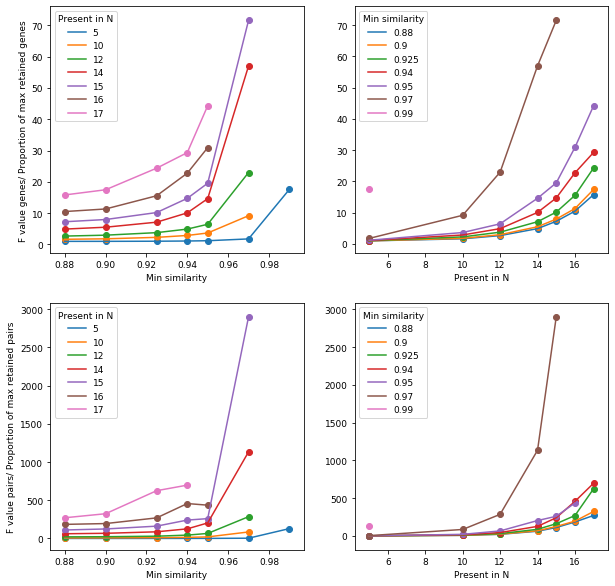

In [36]:
s=NeighbourCalculator.plot_threshold_batched(summary=summary)

On subsets the best similarity threshold is 0.95 and min present threshold 14. 

As min N present is done on half of replicates (where max N present is half smaller compared data from all replicates) it was determined what min present threshold must be used on whole dataset to get similar number of genes. Min present threshold could not be simily multiplied by size difference of subset and whole dataset, as this would lead to selection of less genes than in subsets. The plot shows N of selected genes at similarity threshold 0.95 in subsets (subsamples) and on all replicates (complete results) across different min present thresholds. Vertical line indicates mean number of selected genes in both subsets at min present threshold 14. 

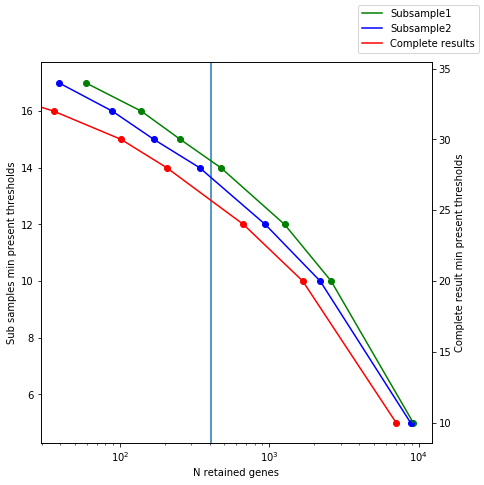

In [37]:
NeighbourCalculator.plot_threshold_batched_sub_vs_all(summary=summary, result_all=results_all, 
                                                      similarity_threshold=0.95,selected_min_present_sub=14)

Similar number of genes to optimal min present threshold in subsets (around 500) would be obtained on all replicates at min present threshold between 25 and 24. Thus threshold of 25 was choosen.

#### Appendix: Summary table

Note that F values are quite small for gene pairs. They seem to be somewhat better for selected genes, indicating that clustering based on selected genes might be more reliable than graph analysis. F values are also affected by different number of genes/pairs in each of two subsets.

In [38]:
display(HTML(summary.to_html(index=False)))

threshold,min_present,n_pairs1,n_genes1,n_pairs2,n_genes2,f_val_genes,f_val_pairs
0.880,5,974088,11840,911424,11792,0.986374,0.406891
0.880,10,45951,5986,39481,5585,0.808573,0.316439
0.880,12,12497,3362,10789,3048,0.724805,0.257236
0.880,14,3061,1549,2745,1329,0.597637,0.190148
0.880,15,1393,919,1285,807,0.529548,0.157580
0.880,16,581,505,581,460,0.429016,0.113597
0.880,17,246,258,226,228,0.325103,0.067797
0.900,5,868062,11703,797215,11628,0.980241,0.409385
0.900,10,41732,5460,34826,5027,0.799085,0.315473
0.900,12,11375,3072,9454,2690,0.722666,0.253493
